In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os 
import warnings

import lifetimes
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions, plot_frequency_recency_matrix

In [2]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Set printed decimal limit
np.set_printoptions(suppress=True)

# Set plot theme
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data <a name="II"></a>

## 1. Download data  <a name="II.1"></a>

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

## 2. Import data <a name="II.2"></a>

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# III. Clean data <a name="III"></a>

Based on our exploratory data analysis, we apply the similar steps to clean the data.

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # Impute AGE column
    df['AGE'].fillna(44, inplace=True)

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]
    
    # Drop redundant columns
    df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

    # Create RACING_TURNOVER column
    df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)
    
    return df

df = clean_data(df)
df.head()

,DATE_DIM,BET_ACCOUNT_NUM_HASH,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER
0,2021-01-01,13154,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288,1118.00
1,2021-01-01,18379,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1,40.00
2,2021-01-01,559232,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5,12.00
3,2021-01-01,698904,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40,1223.50
4,2021-01-01,762921,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5,17.50


In [16]:
# now we can transform the data into a format suitable for the lifetimes package
# can use the summary_data_from_transaction_data function to do this

# we need to transform the data into the canonical RFM format
# frequency - the number of repeat purchases a customer has made
# recency - the age of the customer when they made their most recent purchases
# T - the age of the customer at the end of the period we are analyzing
# monetary_value - the average value of a given customer's purchases, excluding the first purchase

# let's also pass a parameter to so that everything gets converted into weekly frequency

summary_df = summary_data_from_transaction_data(df, 
                                                customer_id_col='BET_ACCOUNT_NUM_HASH', 
                                                datetime_col='DATE_DIM', 
                                                monetary_value_col="TOTAL_TURNOVER",
                                                observation_period_end='2022-12-31',
                                                freq='W')
summary_df.head()

In [19]:
summary_cal_holdout = calibration_and_holdout_data(df,
                                                   customer_id_col='BET_ACCOUNT_NUM_HASH',
                                                   datetime_col='DATE_DIM',
                                                   monetary_value_col='TOTAL_TURNOVER',
                                                   freq='W',
                                                   observation_period_end='2022-12-31',
                                                   calibration_period_end='2022-11-30',
)                                             
                                                   
# let's check the split
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
BET_ACCOUNT_NUM_HASH,,,,,,,
13154,100.00,100.00,100.00,3607.67,5.00,237.43,4.00
18379,92.00,100.00,100.00,322.37,5.00,168.85,4.00
37251,0.00,0.00,4.00,0.00,0.00,0.00,4.00
129273,7.00,45.00,49.00,15.71,4.00,6.25,4.00
348318,2.00,15.00,25.00,10.00,0.00,0.00,4.00


In [21]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

# print details of the model we just created
print(bgf)

# now show the summary of our model
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 141228 subjects, a: 0.09, alpha: 1.75, b: 1.77, r: 0.72>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.72,0.00,0.71,0.72
alpha,1.75,0.01,1.74,1.77
a,0.09,0.00,0.09,0.09
b,1.77,0.03,1.72,1.82


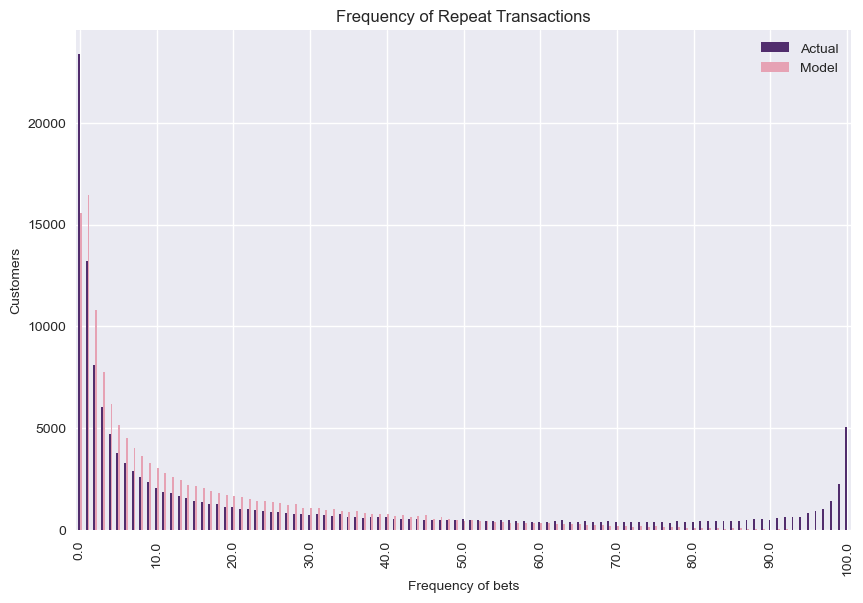

In [23]:
# first let's compare the frequencies between our real data and artificial data 
# the artificial data is sampled from the distributions created in our fitted model bgf

# first import the necessary function
from lifetimes.plotting import plot_period_transactions

# now use this on our bgf object
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6.5)) 
# Call plot_period_transactions on the bgf object
plot_period_transactions(bgf, max_frequency=104, xlabel="Frequency of bets", ax=ax)
# Set the x tick locator
ax.xaxis.set_major_locator(plt.MultipleLocator(10)) 
plt.show()

<Axes: title={'center': 'Expected Number of Future Purchases for 4 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

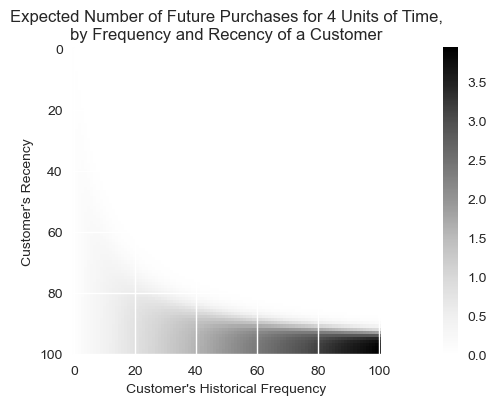

In [47]:
# and plot our matrix
# we can control the time period to predict for using the T argument
# let's plot for the next 4 weeks
plot_frequency_recency_matrix(bgf,
                              T=4, # to control the number of time period to plot for
                              )

In [ ]:
plot_probability_alive_matrix(paretof)
